In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm
import os
import glob
import numpy as np
import shap

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('Feb_25_2022/shap_values.pickle','rb') as handle:
    shap_values = pickle.load(handle)

In [3]:
mgus_list_aiims = pd.read_csv('mgus_common_genes.csv')['Sample'].values.tolist()
mm_list_aiims = pd.read_csv('mm_common_genes.csv')['Sample'].values.tolist()
mgus_list_ega = pd.read_csv('mgus_common_genes.csv')['Sample'].values.tolist()
mm_list_mmrf = pd.read_csv('mm_common_genes.csv')['Sample'].values.tolist()

total_mm_list = mm_list_aiims + mm_list_mmrf
total_mgus_list = mgus_list_ega + mgus_list_aiims
total_list = total_mm_list + total_mgus_list

genelist = open('total_genes_qallsubs_filtered.txt').read().split('\n')[:-1]

# Modules for getting best shap and corrosponding norm data

In [4]:
shap_values_fold1 = shap_values['fold1']
shap_values_fold2 = shap_values['fold2']
shap_values_fold3 = shap_values['fold3']
shap_values_fold4 = shap_values['fold4']
shap_values_fold5 = shap_values['fold5']

In [5]:
def get_shap_samplewise(sample, shap_values_foldno):
    if sample in shap_values_foldno.keys():
        if sample in total_mm_list: #for MM sample
            shap_values = shap_values_foldno[sample]['shap_values'][0]
            exp_value = shap_values_foldno[sample]['base_values'][0]
        else: # For MGUS Sample
            shap_values = shap_values_foldno[sample]['shap_values'][1]
            exp_value = shap_values_foldno[sample]['base_values'][1]

        data_points = shap_values_foldno[sample]['data']
    else:
        print(f'The sample was not correctly mapped in {shap_values_foldno}')
        shap_values, exp_values, data_points = [], [], []
    
    return shap_values, exp_value, data_points

In [6]:
def get_shap_samplewise2(sample):
    correct_cls_dict = {}
    if sample in shap_values_fold1.keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold1)
        correct_cls_dict['fold1'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold2.keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold2)
        correct_cls_dict['fold2'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold3.keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold3)
        correct_cls_dict['fold3'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold4.keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold4)
        correct_cls_dict['fold4'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold5.keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold5)
        correct_cls_dict['fold5'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    return correct_cls_dict

In [7]:
def dominent_shap_for_each_fold(shap_dict, foldno):
    ashap = shap_dict[foldno]['shap_values'].reshape(824,28)
    negative_shap = [(sum(j[j<0])) for j in ashap]
    positive_shap = [(sum(j[j>0])) for j in ashap]
    dominent_shap = [i if np.abs(i)>j else j for (i,j) in zip(negative_shap,positive_shap)]
    return dominent_shap

In [8]:
def features_for_dominent_shap(shap_dict, foldno):
    adata = shap_dict[foldno]['data']
    ashap = shap_dict[foldno]['shap_values'].reshape(824,28)
    dominent_shap = dominent_shap_for_each_fold(shap_dict, foldno)
    shap_for_each_feature = []
    shap_data = []
    for dom in dominent_shap:
        shap_index = dominent_shap.index(dom)
        shap_for_each_feature.append(list(ashap[shap_index]))
        shap_data.append(list(adata[shap_index]))
    return dominent_shap, shap_for_each_feature, shap_data

In [9]:
def get_shap_features(sample):
    sample_shap = get_shap_samplewise2(sample)
    dominent_shap_dict = {}
    best_shap_values = []
    shap_each_feat = []
    expected_values = []
    data_points = []
    for k,v in sample_shap.items():
        shap_out1, shap_out2, shap_out3 = features_for_dominent_shap(sample_shap, k)
        dominent_shap_dict[k] = {}
        dominent_shap_dict[k]['dominent_shap'] = shap_out1
        dominent_shap_dict[k]['shap_for_each_feature'] = shap_out2
        dominent_shap_dict[k]['data'] = shap_out3
        dominent_shap_dict[k]['base_value'] = sample_shap[k]['base_value']

    for j in range(824):
        shap_across_folds = [dominent_shap_dict[k]['dominent_shap'][j] for k in dominent_shap_dict.keys()]
        shap_each_feature_across_folds = [dominent_shap_dict[k]['shap_for_each_feature'][j] for k in dominent_shap_dict.keys()]
        data_points_across_folds = [dominent_shap_dict[k]['data'][j] for k in dominent_shap_dict.keys()]
        base_value_across_folds = [dominent_shap_dict[k]['base_value'] for k in dominent_shap_dict.keys()]
        try:
            idx = shap_across_folds.index(max(np.abs(shap_across_folds)))
            best_shap_values.append(shap_across_folds[idx])
            shap_each_feat.append(shap_each_feature_across_folds[idx])
            expected_values.append(base_value_across_folds[idx])
            data_points.append(data_points_across_folds[idx])
        except: 
            idx = shap_across_folds.index(-max(np.abs(shap_across_folds)))
            best_shap_values.append(shap_across_folds[idx])
            shap_each_feat.append(shap_each_feature_across_folds[idx])
            expected_values.append(base_value_across_folds[idx])
            data_points.append(data_points_across_folds[idx])

    return shap_each_feat, data_points, np.mean(expected_values)

In [10]:
def get_feature_mat(sample):
    if 'MMRF' in sample:
        path = '/home/vivek/extended_feature_matrix/824_genes_grouped_feature_matrix/mmrf'
    elif 'CR-MGUS' in sample:
        path = '/home/vivek/extended_feature_matrix/824_genes_grouped_feature_matrix/ega'
    else:
        path = path = '/home/vivek/extended_feature_matrix/824_genes_grouped_feature_matrix/aiims'
    df = pd.read_csv(os.path.join(path,sample),index_col=0, header=0)
    return df

In [11]:
correctly_mapped_samples = list(set(list(shap_values_fold1.keys()) + list(shap_values_fold2.keys()) + list(shap_values_fold3.keys()) + list(shap_values_fold4.keys()) + list(shap_values_fold5.keys())))

In [12]:
# top500_mm_genes = open('/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/shap_plots/mm_specific/500/mm_top_genes_shap.txt').read().split('\n')
# top500_mm_genes = [i.replace(' ','') for i in top500_mm_genes]
# top500_mgus_genes = open('/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/shap_plots/mgus_specific/500/mgus_top_genes_shap.txt').read().split('\n')
# top500_mgus_genes = [i.replace(' ','') for i in top500_mgus_genes]
# top100_mgus_genes = top500_mgus_genes[:100]
# consensus_genelist = list(set(top500_mm_genes + top100_mgus_genes))
# consensus_genelist.__len__()

In [13]:
driver_list1 = pd.read_csv('/home/vivek/driverGenes_Oncogene_TSG/IntOGen-DriverGenes_MM.tsv',
                           sep = '\t',
                          index_col = 0).index.tolist()
driver_list1 = [i.replace(' ','') for i in driver_list1]
driver_list2 = open('/home/vivek/driverGenes_Oncogene_TSG/list_of_63_driver_genes.txt').read().split('\n')
driver_list2 = [i.replace(' ','') for i in driver_list2]
driver_list3 = open('/home/vivek/driverGenes_Oncogene_TSG/Genomic_landscape_and_chronological_reconstruction_of_driver_events_in_multiple.txt').read().split('\n')
driver_list3 = [i.replace(' ','') for i in driver_list3]
oncodb = pd.read_csv('/home/vivek/driverGenes_Oncogene_TSG/cancerGeneList_onco.txt',sep = '\t',index_col=0)
oncogenes = oncodb[oncodb['Is Oncogene'] == 'Yes'].index.tolist()
tsg = oncodb[oncodb['Is Tumor Suppressor Gene'] == 'Yes'].index.tolist()
cosmic_actionable_gene1 = pd.read_excel('/home/vivek/driverGenes_Oncogene_TSG/LIST_OF_ACTIONABLE_GENE.xlsx').iloc[:,0].tolist()
target_actionable_gene1 = pd.read_excel('/home/vivek/driverGenes_Oncogene_TSG/TARGET_db_v3_02142015.xlsx')['Gene'].values.tolist()
consensus_genelist = list(set(driver_list1 + driver_list2 + driver_list3 + oncogenes + tsg + cosmic_actionable_gene1 + target_actionable_gene1))
consensus_genelist.__len__()

Unknown extension is not supported and will be removed


661

In [14]:
path = '/home/vivek/extended_feature_matrix/824_genes_grouped_feature_matrix/mmrf'
feat_mat = pd.read_csv(os.path.join(path,correctly_mapped_samples[0]),index_col=0, header=0)
feat_mat = feat_mat[feat_mat.index.isin(consensus_genelist)]
feat_names = feat_mat.columns
index_names = feat_mat.index
new_feat_names = [i+'('+j+')' for j in feat_names for i in index_names ]
new_feat_names.__len__()
# feat_mat.shape

1876

In [15]:
shap_df_combined = pd.DataFrame(columns = new_feat_names)
shap_data_df_combined = pd.DataFrame(columns = new_feat_names)
shap_expected_value_combined = []
for sam in tqdm(correctly_mapped_samples):
    shap_values, data_points, expected_values = get_shap_features(sam)
    shap_values = pd.DataFrame(np.array(shap_values).reshape(824,28),index=genelist,columns =feat_mat.columns)
    shap_values = shap_values[shap_values.index.isin(consensus_genelist)]
    data_points = pd.DataFrame(np.array(data_points).reshape(824,28),index=genelist,columns =feat_mat.columns)
    data_points = data_points[data_points.index.isin(consensus_genelist)]
    shap_df_combined.loc[sam.split('.')[0]] = shap_values.to_numpy().flatten()
    shap_data_df_combined.loc[sam.split('.')[0]] = data_points.to_numpy().flatten()
    shap_expected_value_combined.append(expected_values)

100%|██████████| 1163/1163 [02:12<00:00,  8.78it/s]


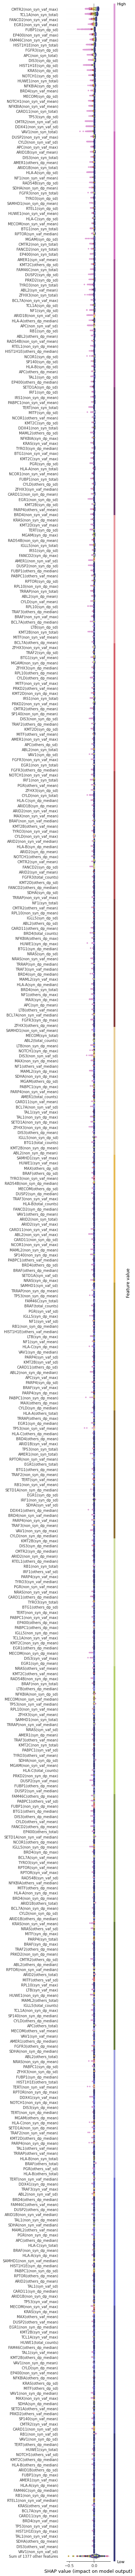

In [16]:
shap.plots.beeswarm(shap.Explanation(np.array(shap_df_combined),
                                     np.array(shap_expected_value_combined),
                                     np.array(shap_data_df_combined),
                                     feature_names = new_feat_names),
                    max_display = 500,
                    show=False,
                    plot_size = (5,100),
                    color = plt.get_cmap("tab20b"))#
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('Feb_25_2022/shap_for_prev_reported_genes.png',dpi=300)

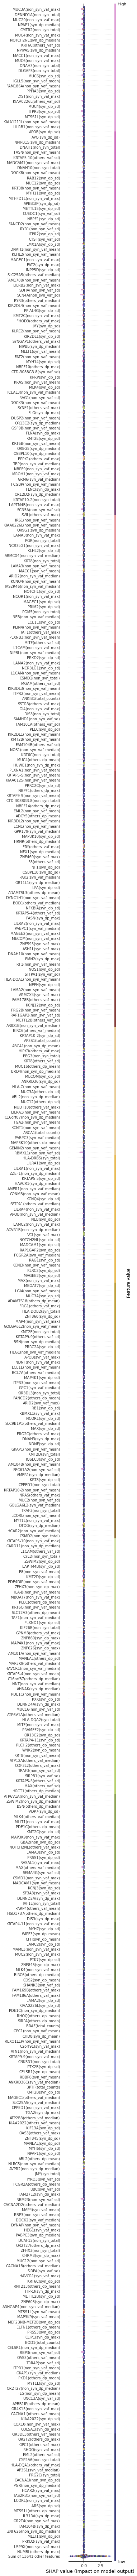

In [28]:
shap.plots.beeswarm(shap.Explanation(np.array(shap_df_combined),
                                     np.array(shap_expected_value_combined),
                                     np.array(shap_data_df_combined),
                                     feature_names = new_feat_names),
                    max_display = 500,
                    show=False,
                    plot_size = (5,100),
                    color = plt.get_cmap("tab20b"))#
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('Feb_25_2022/shap_plots/mm_mgus_combined/824/feature_importance_beeswarm_plot.png',dpi=300)
# plt.savefig('Feb_25_2022/shap_plots/mm_mgus_combined/824/MM_beeswarm_plot.svg', dpi=300)